# Google Top Stories - An exploration

**Description:** This dataset was collected during the pandemic, it contains headlines shown by Google Search.
It is organized by year, month, date, hour, in a series of nested folders. The leaf folders contain JSON files with information about Google's top stories. 

Your goal is to write first a Python function that takes the name of the folder "GoogleTopStories" and stores the content of all the JSON files into a single CSV file. Once you have a CSV file, you can practice your pandas & seaborn skills in analyzing the data.

Some tips and ideas for analysis:
1. Use the Python command `os.walk` to iteratively traverse the nested subfolders. Account for hidden files that start with .
2. Although the dataset has a column domain, imagine that it doesn't have it and write a function that takes a URL and extracts the domain name from it and saves it in a column. Use the `.apply` method to create the column. Learn how to parse URLs with `urllib.parse`.
3. Create a bar chart with the frequencies of the top 10 domains. (Use domains, since 'source name' contains duplicates.)
4. Create a heatmap that shows the distribution of domains across the 'story_position' values.
5. Create timeseries of unique articles per month by query type. (This is challenging, because it is not using pandas' timeseries.)


**Table of Content [Solutions]**
1. [Reading all JSON files](#sec1)
2. [Creating a new column](#sec2)
3. [Bar chart of top domains](#sec3)
4. [Heatmap for the story positions](#sec4)
5. [Timeseries of unique articles by query](#sec5)

<a id="sec1"></a>
## Part 1: Reading all JSON files

Spend some time looking at the structure of the folders and subfolders in GoogleTopStories. You should notice the deep nesting. The function `os.walk` recursively traverses this nested structure. 

In [6]:
import os, json, csv

def writeFilesToCSV(pathName):
    """
    Takes a foldername as an argument. Recursively reads all JSON files 
    and saves their content into a list. At the end, saves all data into a CSV file.
    """
    allTopStories = []
    totalFiles = 0
    for dirpath, dirnames, filenames in os.walk(pathName):
        for fN in filenames: 
            if fN.endswith('.json'): # Avoid any other types of files, such as .DS_Store
                totalFiles += 1
                filePath = os.path.join(dirpath, fN) # create the whole path of a file
                with open(filePath, encoding="utf-8") as inputF:
                    data = json.load(inputF)
                    allTopStories.extend(data)
                
    print("Total number of JSON files:", totalFiles)
    print("Total number of Top stories in the files:", len(allTopStories))

    with open("our-results.csv", "w", encoding="utf-8") as fout:
        header = list(allTopStories[0].keys()) + ['category'] # Notice this, because not all top stories have a "category"
        dW = csv.DictWriter(fout, fieldnames=header)
        dW.writeheader()
        dW.writerows(allTopStories)

In [7]:
# Call the function for our folder
writeFilesToCSV('GoogleTopStories')

Total number of JSON files: 2443
Total number of Top stories in the files: 16948


**Your task: Explore how `os.walk` works**

In order to see how os.walks works, use below the for loop from the function to only explore the month of Aprill 2020, by printing out what the for loop generates.

In [10]:
pathName = 'GoogleTopStories'
for dirpath, dirnames, filenames in os.walk(pathName):
    print(dirpath)
    print(dirnames)
    print(filenames)

GoogleTopStories
['2020', '2021']
[]
GoogleTopStories\2020
['04', '05', '06', '07', '08', '09', '10', '11', '12']
[]
GoogleTopStories\2020\04
['25', '26', '27', '28', '29', '30']
['.DS_Store']
GoogleTopStories\2020\04\25
['10pm']
['.DS_Store']
GoogleTopStories\2020\04\25\10pm
['.ipynb_checkpoints']
['coronavirus symptoms.json', 'coronavirus test.json', 'coronavirus.json', 'Covid-19.json']
GoogleTopStories\2020\04\25\10pm\.ipynb_checkpoints
[]
['coronavirus symptoms-checkpoint.json']
GoogleTopStories\2020\04\26
['10am', '10pm']
['.DS_Store']
GoogleTopStories\2020\04\26\10am
[]
['coronavirus symptoms.json', 'coronavirus test.json', 'coronavirus.json', 'Covid-19.json']
GoogleTopStories\2020\04\26\10pm
[]
['coronavirus symptoms.json', 'coronavirus test.json', 'coronavirus.json', 'Covid-19.json']
GoogleTopStories\2020\04\27
['10am', '10pm']
[]
GoogleTopStories\2020\04\27\10am
[]
['coronavirus symptoms.json', 'coronavirus test.json', 'coronavirus.json', 'Covid-19.json']
GoogleTopStories\2020

<a id="sec2"></a>
## Part 2: Create the new `domain` column

Let's load the data that we created in Part 1 into a dataframe.

In [11]:
import pandas as pd

df = pd.read_csv('our-results.csv')
df.head()

,title,url,source,time,date,query,story_position,domain,category
0,Six new coronavirus symptoms just officially a...,https://www.miamiherald.com/news/coronavirus/a...,Miami Herald,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,1,www.miamiherald.com,NaN
1,Coronavirus FAQs: Are There Lots Of Cases With...,https://www.npr.org/sections/goatsandsoda/2020...,NPR,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,2,www.npr.org,NaN
2,CDC adds 6 new possible coronavirus symptoms,https://www.ktvq.com/news/coronavirus/cdc-adds...,KTVQ.com,2 hours ago,2020-04-25 22:00:00,coronavirus symptoms,3,www.ktvq.com,NaN
3,WHO says no evidence shows that having coronav...,https://www.cnn.com/2020/04/25/us/who-immunity...,CNN.com,6 hours ago,2020-04-25 22:00:00,coronavirus test,1,www.cnn.com,NaN
4,'No Evidence' Yet That Recovered COVID-19 Pati...,https://www.npr.org/sections/coronavirus-live-...,NPR,11 hours ago,2020-04-25 22:00:00,coronavirus test,2,www.npr.org,NaN


**How to extract the domain name from the URL?**

In [12]:
from urllib.parse import urlparse

oneUrl = df.iloc[0]['url'] # retrieve url from first row of dataframe
urlparse(oneUrl)

ParseResult(scheme='https', netloc='www.miamiherald.com', path='/news/coronavirus/article242260231.html', params='', query='', fragment='')

Notice that the result is an object and the domain name is the value of the attribute `netloc`. Now, we can easily make use of this to write the helper function to extract the domain name.

**Write a helper function**

In [13]:
from urllib.parse import urlparse

def getDomain(field):
    """returns the domain name of a url"""
    return urlparse(field).netloc


Apply the helper function to the whole column and store the results to a new column:

In [14]:
df['domain2'] = df['url'].apply(getDomain)
df.head()

,title,url,source,time,date,query,story_position,domain,category,domain2
0,Six new coronavirus symptoms just officially a...,https://www.miamiherald.com/news/coronavirus/a...,Miami Herald,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,1,www.miamiherald.com,NaN,www.miamiherald.com
1,Coronavirus FAQs: Are There Lots Of Cases With...,https://www.npr.org/sections/goatsandsoda/2020...,NPR,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,2,www.npr.org,NaN,www.npr.org
2,CDC adds 6 new possible coronavirus symptoms,https://www.ktvq.com/news/coronavirus/cdc-adds...,KTVQ.com,2 hours ago,2020-04-25 22:00:00,coronavirus symptoms,3,www.ktvq.com,NaN,www.ktvq.com
3,WHO says no evidence shows that having coronav...,https://www.cnn.com/2020/04/25/us/who-immunity...,CNN.com,6 hours ago,2020-04-25 22:00:00,coronavirus test,1,www.cnn.com,NaN,www.cnn.com
4,'No Evidence' Yet That Recovered COVID-19 Pati...,https://www.npr.org/sections/coronavirus-live-...,NPR,11 hours ago,2020-04-25 22:00:00,coronavirus test,2,www.npr.org,NaN,www.npr.org


**Your Task: Create a new column**

Create a new column that will store the number of words on the title of each article. The column name should be `wordCount`. Show the head of the dataframe to indicate that the column was created.

In [17]:
def wordCount(string):
    return len(string.split())

In [18]:
df['wordCount'] = df['title'].apply(wordCount)
df.head()

,title,url,source,time,date,query,story_position,domain,category,domain2,wordCount
0,Six new coronavirus symptoms just officially a...,https://www.miamiherald.com/news/coronavirus/a...,Miami Herald,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,1,www.miamiherald.com,NaN,www.miamiherald.com,13
1,Coronavirus FAQs: Are There Lots Of Cases With...,https://www.npr.org/sections/goatsandsoda/2020...,NPR,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,2,www.npr.org,NaN,www.npr.org,19
2,CDC adds 6 new possible coronavirus symptoms,https://www.ktvq.com/news/coronavirus/cdc-adds...,KTVQ.com,2 hours ago,2020-04-25 22:00:00,coronavirus symptoms,3,www.ktvq.com,NaN,www.ktvq.com,7
3,WHO says no evidence shows that having coronav...,https://www.cnn.com/2020/04/25/us/who-immunity...,CNN.com,6 hours ago,2020-04-25 22:00:00,coronavirus test,1,www.cnn.com,NaN,www.cnn.com,12
4,'No Evidence' Yet That Recovered COVID-19 Pati...,https://www.npr.org/sections/coronavirus-live-...,NPR,11 hours ago,2020-04-25 22:00:00,coronavirus test,2,www.npr.org,NaN,www.npr.org,11


<a id="sec3"></a>
## Part 3: Bar chart of top 10 domains

To create the bar chart of the top 10 domains, we first need to find the top 10 domains.

The method `value_counts` returns a **sorted** series of counts for each value in a column.

In [19]:
# Find the top 10 domains using value_counts
domainCounts = df['domain'].value_counts()[:10]

Let's see what it looks like:

In [20]:
domainCounts

domain
www.cnn.com               1834
www.nytimes.com           1246
www.washingtonpost.com     826
www.foxnews.com            801
www.cnbc.com               577
www.npr.org                544
www.usatoday.com           492
www.nbcnews.com            492
thehill.com                477
nypost.com                 459
Name: count, dtype: int64

Let's look up the type of our our result:

In [21]:
type(domainCounts)

pandas.core.series.Series

Since the result is a Series, we will convert it to a dataframe. [**Note:** The method `reset_index` converts a Series into a DataFrame, where the original index becomes a column in the DataFrame, and the Series values occupies another column, for which we have to provide a column name.]

In [22]:
data = domainCounts.reset_index(name='count')
data

,domain,count
0,www.cnn.com,1834
1,www.nytimes.com,1246
2,www.washingtonpost.com,826
3,www.foxnews.com,801
4,www.cnbc.com,577
5,www.npr.org,544
6,www.usatoday.com,492
7,www.nbcnews.com,492
8,thehill.com,477
9,nypost.com,459


Now that we have a dataframe we can use Seaborn to generate charts. Below I'm creating a bar plot.

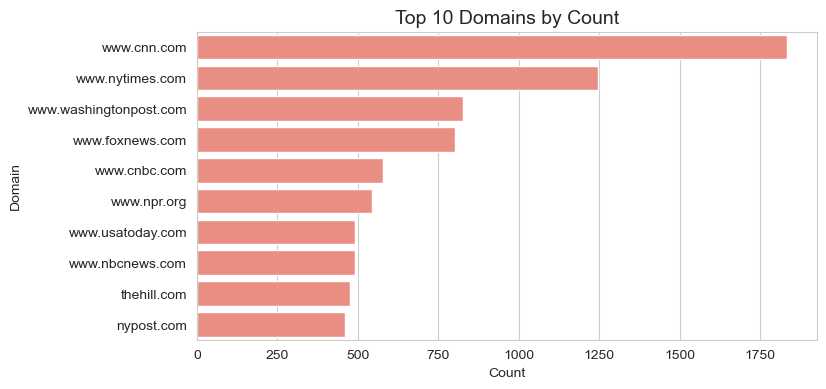

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))   # adjusting the size of the figure where the plot will be displayed
sns.set_style("whitegrid")  

# Create the horizontal bar plot
ax = sns.barplot(x='count', y='domain', data=data, color="salmon")

# Set titles
ax.set_xlabel("Count", fontsize=10)
ax.set_ylabel("Domain", fontsize=10)
ax.set_title("Top 10 Domains by Count", fontsize=14)

# Display the plot
plt.show()

**Your Task: Create a bar chart of query occurrences**

Adapt the code above to generate the bar chart of the query occurrences. Make sure that you change the barplot titles to reflect the new variable being displayed. Change the color of the graph and [visit this Seaborn documentation page](https://seaborn.pydata.org/tutorial/aesthetics.html) for inspiration on changing the style of the plot.

In [26]:
queryCounts = df['query'].value_counts()[:10]

In [33]:
queryCountsDF = pd.DataFrame(queryCounts).reset_index()
queryCountsDF

,query,count
0,coronavirus,5009
1,Covid-19,4984
2,Anthony Fauci,3981
3,coronavirus symptoms,1560
4,coronavirus test,1414


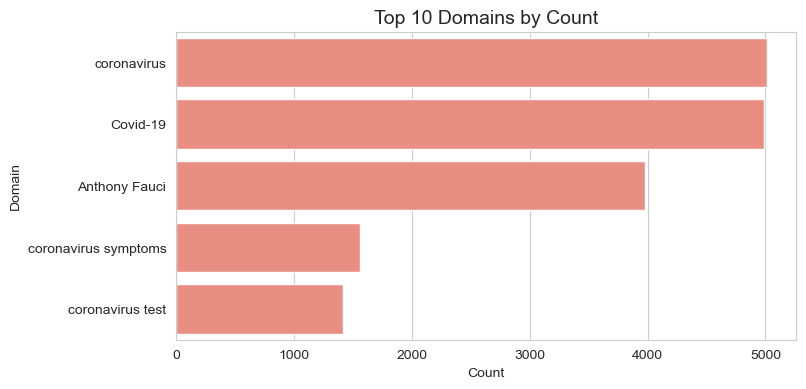

In [34]:
plt.figure(figsize=(8, 4))   # adjusting the size of the figure where the plot will be displayed
sns.set_style("whitegrid")  

# Create the horizontal bar plot
ax = sns.barplot(x='count', y='query', data=queryCountsDF, color="salmon")

# Set titles
ax.set_xlabel("Count", fontsize=10)
ax.set_ylabel("Domain", fontsize=10)
ax.set_title("Top 10 Domains by Count", fontsize=14)

# Display the plot
plt.show()

<a id="sec4"></a>
## Part 4: Heatmap for the story positions

We are interested in the question: Are all news sources equally likely to show up in all positions? Or some of them show up more frequently in a certain position? To explore this question visually, we will create a heatmap. However, since there are hundreds of news sources in our dataset, we will focus only on the top 10 for simplicity.

In [35]:
# First, find the names of the top 10 domains
# Then, filter the dataframe to select only the rows of one of the top 10 domains (articles that belong to these news domains)

topTen = df['domain'].value_counts()[:10].index.tolist() # remember from part 3 that value_counts returns a Series and the 'domain' column is the index of it
dfSmall = df[df['domain'].isin(topTen)] # do the filtering. Notice the filter syntax.
dfSmall.shape

(7748, 11)

As a reminder, here is what the size of the whole dataframe is:

In [36]:
df.shape

(16948, 11)

Let's calcuate the proportion of articles from the top 10 domains:

In [37]:
proportion = dfSmall.shape[0]/df.shape[0] * 100
proportion

45.71630870899221

**Question:** What does the fact that the proportion of the occurrences of the top 10 domains comes at 45% tell us about Google's algorithms?

**Your Answer:** Google promotes these 10 sources a lot

### Creating a pivot table

Our current dataframe, `dfSmall` presents itself as a **tidy table**, each row is an observation. We will now convert it to a form that it is not a **tidy table**, because the columns will become values of the variable "story_position". This will allow us to count how many domains show up in each of the 10 positions.

To create such a table we will use pandas' `pivot_table` method, which builds upon the `groupby` method that we have seen.

In [38]:
# First, let's create the pivot table to count each domain occurrence by position

dfFinal = dfSmall[['domain', 'story_position']] # work with a two-column dataframe

pivotDF = dfFinal.pivot_table(index='domain', columns='story_position', 
                              aggfunc='size',fill_value=0)
pivotDF.head(10)

story_position,1,2,3,4,5,6,7,8,9,10
domain,,,,,,,,,,
nypost.com,64,65,75,37,33,37,41,39,36,32
thehill.com,32,43,82,70,62,28,39,55,37,29
www.cnbc.com,103,77,57,50,49,53,39,38,51,60
www.cnn.com,479,480,190,98,82,138,122,100,80,65
www.foxnews.com,99,101,137,79,74,87,56,60,55,53
www.nbcnews.com,30,63,51,36,41,38,64,58,51,60
www.npr.org,86,108,42,21,22,41,48,55,65,56
www.nytimes.com,634,274,75,22,29,42,47,51,38,34
www.usatoday.com,47,61,74,33,31,48,49,49,52,48


Now that we have a dataframe, let's normalize the rows by dividing each cell in a column by the sum of values of that row:

In [39]:
normalized = pivotDF.div(pivotDF.sum(axis=1), # first generate the sum of values in each row
                         axis=0) # then divide all cells in a colum, by the corresponding sum
normalized

story_position,1,2,3,4,5,6,7,8,9,10
domain,,,,,,,,,,
nypost.com,0.139434,0.141612,0.163399,0.080610,0.071895,0.080610,0.089325,0.084967,0.078431,0.069717
thehill.com,0.067086,0.090147,0.171908,0.146751,0.129979,0.058700,0.081761,0.115304,0.077568,0.060797
www.cnbc.com,0.178510,0.133449,0.098787,0.086655,0.084922,0.091854,0.067591,0.065858,0.088388,0.103986
www.cnn.com,0.261178,0.261723,0.103599,0.053435,0.044711,0.075245,0.066521,0.054526,0.043621,0.035442
www.foxnews.com,0.123596,0.126092,0.171036,0.098627,0.092385,0.108614,0.069913,0.074906,0.068664,0.066167
www.nbcnews.com,0.060976,0.128049,0.103659,0.073171,0.083333,0.077236,0.130081,0.117886,0.103659,0.121951
www.npr.org,0.158088,0.198529,0.077206,0.038603,0.040441,0.075368,0.088235,0.101103,0.119485,0.102941
www.nytimes.com,0.508828,0.219904,0.060193,0.017657,0.023274,0.033708,0.037721,0.040931,0.030498,0.027287
www.usatoday.com,0.095528,0.123984,0.150407,0.067073,0.063008,0.097561,0.099593,0.099593,0.105691,0.097561


Now that the data is ready, we can create the heatmap, providing some additional instructions to make it look good:

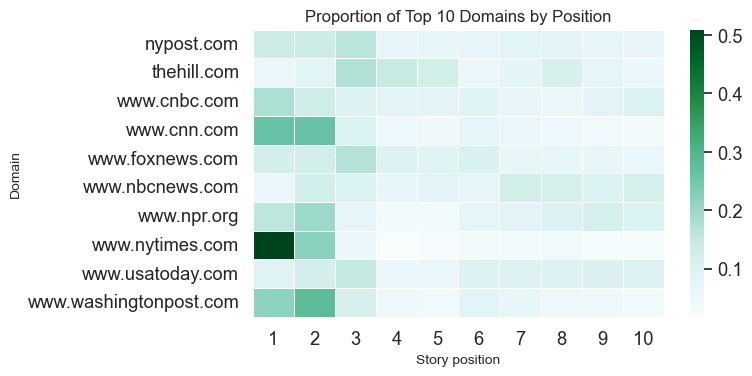

In [40]:
# Create a heatmap
plt.figure(figsize=(8, 4))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(normalized, 
            cmap='BuGn', # set color map Blue to Green
            annot=False, # do not show the numerical values in each cell
            linewidths=0.5) # width of lines that separate the cells in the map

# We are directly setting the properties of the current axes, without explicitely referring to it as we did in the barplot image
plt.xlabel('Story position', fontsize=10)
plt.ylabel('Domain', fontsize=10)
plt.title('Proportion of Top 10 Domains by Position', fontsize=12)

plt.tight_layout()
plt.show()

**Questions:** Given this visualization, how can we answer our starting question: Are all news sources equally likely to show up in all positions?  
Furthermore, what does this tell us about Google's algorithms?

**Your Answer:** No, NYT, CNN and WaPo are more likely to show in the top 2. The Hill is more likely to show at the top 3-5. 

<a id="sec5"></a>
## 5. Timeseries of monthly unique articles organized by query type

From prior experience in working with Google Top Stories data, I know that some articles show up multiple times during the day or over a few days. We can verify this through code:

In [41]:
df.url.unique().size == df.url.size # compare sizes

False

Print the sizes to compare unique url to the total urls:

In [42]:
print(f"Unique: {df.url.unique().size}, Total: {df.url.size}")

Unique: 12265, Total: 16948


**Your Task: Domains and Sources**  
Throughout the notebook, we worked with the domain column, instead of source. 
1. Check if these two columns have the same size in terms of unique values.
2. What is the size of unique values for each of them?
3. Speculate about the reason for the divergence between the two columns.

**Your exploration**

In [46]:
df.domain.unique().size == df.source.unique().size # compare sizes

False

In [47]:
df.source.unique().size

1048

In [48]:
df.domain.unique().size

811

Perhaps the reason for this difference is that multiple sources share domains? Or a source is sharing the news of another source?

### Focus on unique articles

Let's start by dropping all the rows that have repeating URLs, however, we will first sort the rows, so that they are in the order of publication.

In [51]:
df.sort_values(by=['date'], inplace=True)
df.head()

,title,url,source,time,date,query,story_position,domain,category,domain2,wordCount
0,Six new coronavirus symptoms just officially a...,https://www.miamiherald.com/news/coronavirus/a...,Miami Herald,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,1,www.miamiherald.com,NaN,www.miamiherald.com,13
28,CDC adds 6 new possible coronavirus symptoms,https://www.ktvq.com/news/coronavirus/cdc-adds...,KTVQ.com,2 hours ago,2020-04-25 22:00:00,coronavirus symptoms,3,www.ktvq.com,NaN,www.ktvq.com,7
27,Coronavirus FAQs: Are There Lots Of Cases With...,https://www.npr.org/sections/goatsandsoda/2020...,NPR,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,2,www.npr.org,NaN,www.npr.org,19
26,Six new coronavirus symptoms just officially a...,https://www.miamiherald.com/news/coronavirus/a...,Miami Herald,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,1,www.miamiherald.com,NaN,www.miamiherald.com,13
25,UPDATE: Governor's office says 'Phase One' of ...,https://www.richmond.com/news/virginia/update-...,Richmond Times-Dispatch,10 hours ago,2020-04-25 22:00:00,Covid-19,10,www.richmond.com,NaN,www.richmond.com,23


We can see from the indices (they don't start at 0 any longer) that the rows were sorted. Let's drop the duplicate URLs:

In [52]:
dfUnique = df.drop_duplicates(subset=['url']) 
dfUnique.shape

(12265, 11)

I will create a new column, year-month, since the date field is too granular. [**Note**: Read more about this at the end of the notebook.]

In [53]:
def splitDate(row):
    """return a date in the format YYYY-MM"""
    return row['date'][:7] 

dfUnique['year-month'] = dfUnique.apply(splitDate, axis=1)
dfUnique.head()

C:\Users\lilli\AppData\Local\Temp\ipykernel_21784\1694280622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique['year-month'] = dfUnique.apply(splitDate, axis=1)


,title,url,source,time,date,query,story_position,domain,category,domain2,wordCount,year-month
0,Six new coronavirus symptoms just officially a...,https://www.miamiherald.com/news/coronavirus/a...,Miami Herald,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,1,www.miamiherald.com,NaN,www.miamiherald.com,13,2020-04
28,CDC adds 6 new possible coronavirus symptoms,https://www.ktvq.com/news/coronavirus/cdc-adds...,KTVQ.com,2 hours ago,2020-04-25 22:00:00,coronavirus symptoms,3,www.ktvq.com,NaN,www.ktvq.com,7,2020-04
27,Coronavirus FAQs: Are There Lots Of Cases With...,https://www.npr.org/sections/goatsandsoda/2020...,NPR,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,2,www.npr.org,NaN,www.npr.org,19,2020-04
25,UPDATE: Governor's office says 'Phase One' of ...,https://www.richmond.com/news/virginia/update-...,Richmond Times-Dispatch,10 hours ago,2020-04-25 22:00:00,Covid-19,10,www.richmond.com,NaN,www.richmond.com,23,2020-04
24,Maine reports 3 more COVID-19 deaths as the st...,https://bangordailynews.com/2020/04/25/news/st...,Bangor Daily News,9 hours ago,2020-04-25 22:00:00,Covid-19,9,bangordailynews.com,NaN,bangordailynews.com,13,2020-04


**Important Note:** When running the cell above, some of you might have received the following warning:  
A value is trying to be set on a copy of a slice from a DataFrame.

When we run the statement `dfUnique = df.drop_duplicates(subset=['url'])` we intended to create a new dataframe. However, pandas warns us because it can't guarantee that dfUnique isn't sharing data with df under the hood due to its optimizations. The longer explanation is that pandas sometimes uses views internally to optimize memory usage. When we perform an operation that could be ambiguous, such as modifying a DataFrame that could potentially be a view of another DataFrame, pandas issues a warning.

If we don't want the warning to show, we should explicitely tell pandas make a new copy:

`dfUnique = df.drop_duplicates(subset=['url']).copy()`

### Pivot Table: counting articles per query

Now that each row has a month value, we can create a pivot table to count how many time a query showed in each month.

In [54]:
queryMonthDF = dfUnique.pivot_table(index="query", 
                                    columns="year-month", 
                                    aggfunc="size", 
                                    fill_value=0)
queryMonthDF.head()

year-month,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02
query,,,,,,,,,,,
Anthony Fauci,0,173,292,315,154,217,266,222,204,213,57
Covid-19,103,543,537,482,344,424,490,466,411,435,126
coronavirus,102,514,510,456,342,407,464,421,380,390,109
coronavirus symptoms,52,97,94,93,73,80,94,76,77,94,24
coronavirus test,37,126,73,48,61,102,108,102,82,83,20


Let's validate that all articles are shown in this table:

In [55]:
queryMonthDF.sum().sum()

12265

It's looks right!

### Generate the time series plot

There are many ways to create a time series plot. Because I gave you this task before you had seen pandas timeseries, below I will show how to create the plot using linebars. There are two ways to do this.

**Soution 1: Plot line bars with a for loop**

Because the table we created above is a pivot table, also known as a "wide table" (different from the "tidy table"), seaborn doesn't know how to work with it directly, so we have to generate each line within a for loop. 

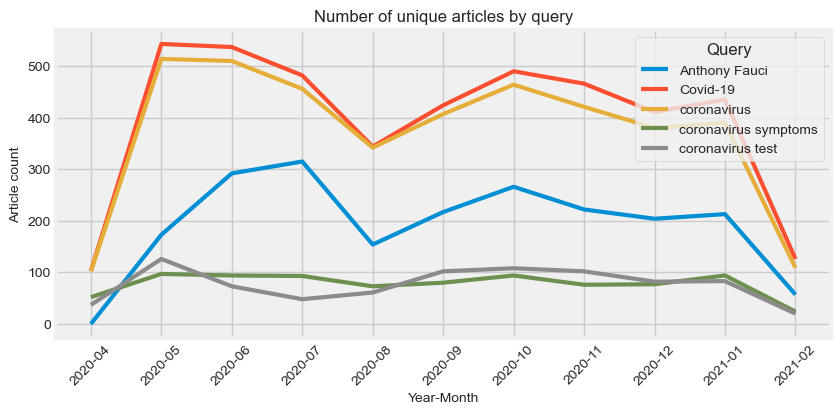

In [56]:
plt.figure(figsize=(10, 4))
plt.style.use('fivethirtyeight')

# Iterate over each row to plot
for index, row in queryMonthDF.iterrows():
    sns.lineplot(x=queryMonthDF.columns,  # the year-month values
                 y=row.values,  # the counts for each query
                 label=index, # this will be the query values
                 lw=3)

# Change the parameters of the current axes (plot) to deal with the font size
plt.xticks(rotation=45) # Rotate dates
plt.ylabel('Article count', fontsize=10)
plt.xlabel('Year-Month', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Number of unique articles by query', fontsize=12)
plt.legend(title='Query', fontsize=10, loc="upper right", title_fontsize=12)

plt.show()

**Solution 2: Wide table vs. long table**

We mentioned that the `pivot_table` method creates a **wide format table**. Seaborn prefers to work with a **long format table** (we called it the tidy data).  
Thus, we will convert the wide table to a long table.

First, let's look again at our wide-format table:

In [57]:
queryMonthDF

year-month,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02
query,,,,,,,,,,,
Anthony Fauci,0,173,292,315,154,217,266,222,204,213,57
Covid-19,103,543,537,482,344,424,490,466,411,435,126
coronavirus,102,514,510,456,342,407,464,421,380,390,109
coronavirus symptoms,52,97,94,93,73,80,94,76,77,94,24
coronavirus test,37,126,73,48,61,102,108,102,82,83,20


Notice that the first column, query, is also serving as an index column. Eventually, what we want is to **unpivot** this table and create a table that looks like this:

```
query year-month count
Anthony Fauci 2020-04 0
Anthony Fauci 2020-05 175
Anthony Fauci 2020-06 304
...
Covid-19 2020-04 102
Covid-19 2020-04 531
...
```

That is from a table that now has 11 colums x 5 rows, we want a table with 3 columns and 55 rows (from wide to long).

The method `melt` below will perform this:

In [58]:
dfLongTab = queryMonthDF.reset_index().melt(id_vars='query',  # column that remains an "identifier" column, will not be melted
                                          var_name='year-month', # name for variable column created after the melting (this contains names of melted columns)
                                          value_name='count') # column created after melting (contains values of melted columns)
dfLongTab.head()

,query,year-month,count
0,Anthony Fauci,2020-04,0
1,Covid-19,2020-04,103
2,coronavirus,2020-04,102
3,coronavirus symptoms,2020-04,52
4,coronavirus test,2020-04,37


Let's check the shape of the created dataframe. 

In [59]:
dfLongTab.shape

(55, 3)

It's exactly what we expected!

Now that we have the data in the desired format, we can do the plotting without having to use a for loop to iterate through the lines, seaborn will do that itself.

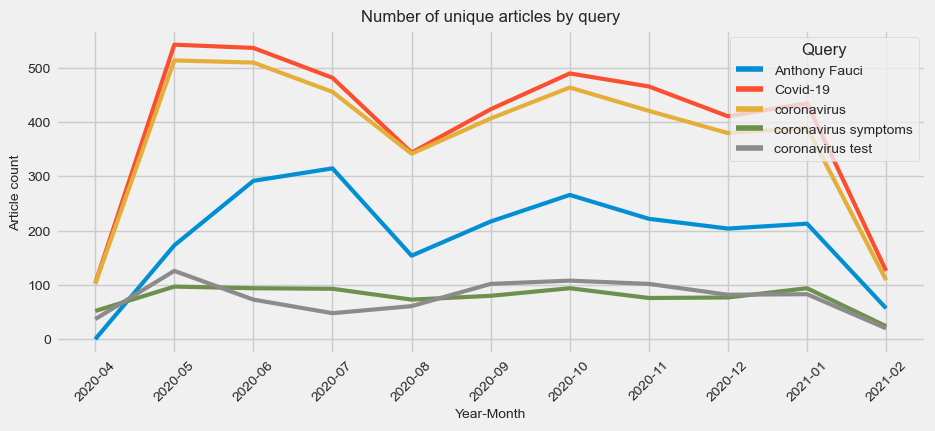

In [60]:
plt.figure(figsize=(10, 4))
plt.style.use('fivethirtyeight')

sns.lineplot(data=dfLongTab, 
             x='year-month', 
             y='count', 
             hue='query', lw=3)

# Change the parameters of the current axes (plot) to deal with the font size
plt.xticks(rotation=45) # Rotate dates
plt.ylabel('Article count', fontsize=10)
plt.xlabel('Year-Month', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Number of unique articles by query', fontsize=12)
plt.legend(title='Query', fontsize=10, loc="upper right", title_fontsize=12)

plt.show()

Notice that we produced the same graph but with two different starting dataframes and code for generating the lines. 

**Your Task: Plot each month**

Using the code above, create two functions:
1. Create a function that given a year-month value, for example: "2020-05", prepares the dataframe that contains the "month-day" counts of the unique articles for each query.
2. Create a function that can take the output from point 1) and plot the lineplot.

Excecute these functions for at least two dates.

In [63]:
dfUnique[dfUnique['year-month'] == '2020-05']

,title,url,source,time,date,query,story_position,domain,category,domain2,wordCount,year-month
370,Coronavirus updates: City to legally challenge...,https://abcnews.go.com/US/coronavirus-live-upd...,ABC News,1 hour ago,2020-05-01 10:00:00,coronavirus,6,abcnews.go.com,NaN,abcnews.go.com,10,2020-05
371,America open for business: States including Te...,https://www.foxnews.com/us/america-open-for-bu...,Fox News,3 hours ago,2020-05-01 10:00:00,coronavirus,7,www.foxnews.com,NaN,www.foxnews.com,15,2020-05
372,"When will US reach 100,000 deaths? After a hor...",https://www.usatoday.com/story/news/nation/202...,USA Today,3 hours ago,2020-05-01 10:00:00,coronavirus,8,www.usatoday.com,NaN,www.usatoday.com,16,2020-05
373,Coronavirus Canceled Warren Buffett’s Sharehol...,https://www.wsj.com/articles/coronavirus-cance...,Wall Street Journal,4 hours ago,2020-05-01 10:00:00,coronavirus,9,www.wsj.com,NaN,www.wsj.com,9,2020-05
374,"Target, Walmart workers and others plan 'sicko...",https://www.nbcnews.com/news/us-news/target-wa...,NBC News,5 hours ago,2020-05-01 10:00:00,coronavirus,10,www.nbcnews.com,NaN,www.nbcnews.com,11,2020-05
...,...,...,...,...,...,...,...,...,...,...,...,...
2295,Juan Williams: Protests are a build up of coro...,https://www.foxnews.com/media/juan-williams-fl...,Fox News,22 mins ago,2020-05-31 22:00:00,coronavirus,3,www.foxnews.com,NaN,www.foxnews.com,17,2020-05
2298,Pssst... Your face mask isn't a coronavirus fo...,https://www.cnet.com/health/pssst-your-face-ma...,CNET.com,2 hours ago,2020-05-31 22:00:00,coronavirus,6,www.cnet.com,NaN,www.cnet.com,9,2020-05
2294,Big-city Dems who had imposed strict coronavir...,https://www.foxnews.com/politics/george-floyd-...,Fox News,9 hours ago,2020-05-31 22:00:00,coronavirus,2,www.foxnews.com,NaN,www.foxnews.com,15,2020-05
2279,The second wave of coronavirus cases could com...,https://www.wusa9.com/article/news/health/coro...,WUSA9.com,6 hours ago,2020-05-31 22:00:00,Anthony Fauci,3,www.wusa9.com,NaN,www.wusa9.com,13,2020-05


In [67]:
"2020-05-01 10:00:00"[5:10]

'05-01'

In [69]:
def splitDate(row):
    """return a date in the format YYYY-MM"""
    return row['date'][5:10] 

dfUnique['month-day'] = dfUnique.apply(splitDate, axis=1)
dfUnique.head()

C:\Users\lilli\AppData\Local\Temp\ipykernel_21784\879638083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique['month-day'] = dfUnique.apply(splitDate, axis=1)


,title,url,source,time,date,query,story_position,domain,category,domain2,wordCount,year-month,month-day
0,Six new coronavirus symptoms just officially a...,https://www.miamiherald.com/news/coronavirus/a...,Miami Herald,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,1,www.miamiherald.com,NaN,www.miamiherald.com,13,2020-04,04-25
28,CDC adds 6 new possible coronavirus symptoms,https://www.ktvq.com/news/coronavirus/cdc-adds...,KTVQ.com,2 hours ago,2020-04-25 22:00:00,coronavirus symptoms,3,www.ktvq.com,NaN,www.ktvq.com,7,2020-04,04-25
27,Coronavirus FAQs: Are There Lots Of Cases With...,https://www.npr.org/sections/goatsandsoda/2020...,NPR,1 day ago,2020-04-25 22:00:00,coronavirus symptoms,2,www.npr.org,NaN,www.npr.org,19,2020-04,04-25
25,UPDATE: Governor's office says 'Phase One' of ...,https://www.richmond.com/news/virginia/update-...,Richmond Times-Dispatch,10 hours ago,2020-04-25 22:00:00,Covid-19,10,www.richmond.com,NaN,www.richmond.com,23,2020-04,04-25
24,Maine reports 3 more COVID-19 deaths as the st...,https://bangordailynews.com/2020/04/25/news/st...,Bangor Daily News,9 hours ago,2020-04-25 22:00:00,Covid-19,9,bangordailynews.com,NaN,bangordailynews.com,13,2020-04,04-25


In [77]:
def findMonth(df,yrmth):
    newDF = df[df['year-month'] == yrmth]
    
    df = newDF.pivot_table(index="query", 
                            columns="month-day", 
                            aggfunc="size", 
                            fill_value=0)
    
    dfLongTab = df.reset_index().melt(id_vars='query',  # column that remains an "identifier" column, will not be melted
                                          var_name='month-day', # name for variable column created after the melting (this contains names of melted columns)
                                          value_name='count')
    
    return dfLongTab
    
data = findMonth(dfUnique,'2020-05')

In [78]:
data

,query,month-day,count
0,Anthony Fauci,05-01,0
1,Covid-19,05-01,19
2,coronavirus,05-01,19
3,coronavirus symptoms,05-01,3
4,coronavirus test,05-01,17
...,...,...,...
150,Anthony Fauci,05-31,5
151,Covid-19,05-31,18
152,coronavirus,05-31,18
153,coronavirus symptoms,05-31,2


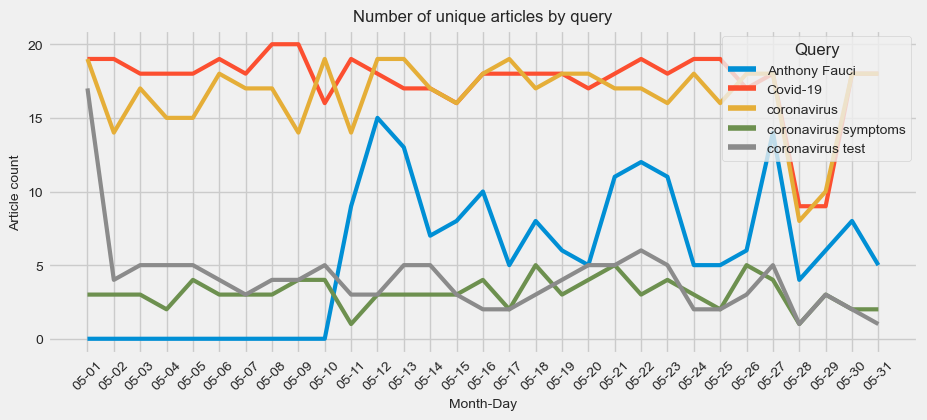

In [80]:
plt.figure(figsize=(10, 4))
plt.style.use('fivethirtyeight')

sns.lineplot(data=data, 
             x='month-day', 
             y='count', 
             hue='query', lw=3)

# Change the parameters of the current axes (plot) to deal with the font size
plt.xticks(rotation=45) # Rotate dates
plt.ylabel('Article count', fontsize=10)
plt.xlabel('Month-Day', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Number of unique articles by query', fontsize=12)
plt.legend(title='Query', fontsize=10, loc="upper right", title_fontsize=12)

plt.show()